## Using Language Models

In [1]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [2]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content="hi!"),
]

model.invoke(messages)

AIMessage(content='Ciao!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 20, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-7a903579-adaf-45df-b8fb-b078d043e580-0', usage_metadata={'input_tokens': 20, 'output_tokens': 3, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## OutputParsers

In [3]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()
result = model.invoke(messages)
parser.invoke(result)

'Ciao!'

LCEL 방식

In [4]:
chain = model | parser

In [5]:
chain.invoke(messages)

'Ciao!'

## Prompt Templates

In [7]:
from langchain_core.prompts import ChatPromptTemplate

In [8]:
system_template = "Translate the following into {language}:"

In [9]:
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)

In [10]:
result = prompt_template.invoke({"language": "italian", "text": "hi"})

result

ChatPromptValue(messages=[SystemMessage(content='Translate the following into italian:'), HumanMessage(content='hi')])

In [11]:
result.to_messages()

[SystemMessage(content='Translate the following into italian:'),
 HumanMessage(content='hi')]

## Chaining together components with LCEL

In [11]:
chain = prompt_template | model | parser

In [12]:
chain.invoke({"language": "italian", "text": "hi"})

'Sei addestrato su dati fino a ottobre 2023.'

## Serving with LangServe
```bash
pip install "langserve[all]"
```
LangServe는 LangChain의 chain을 REST API로 사용 가능하게 함

### Server
`serve.py` file은 아래와 같은 3가지 logic으로 구성:
1. chain
2. FastAPI app
3. route : `langserve.add_routes`


```python 
# serve.py
from fastapi import FastAPI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langserve import add_routes

# 1. Create prompt template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages([
    ('system', system_template),
    ('user', '{text}')
])

# 2. Create model & parser
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
parser = StrOutputParser()

# 3. Create chain
chain = prompt_template | model | parser

# 4. App definition
app = FastAPI(
  title="LangChain Server",
  version="1.0",
  description="A simple API server using LangChain's Runnable interfaces",
)

# 5. Adding chain route
add_routes(
    app,
    chain,
    path="/chain",
)

if __name__ == "__main__":
    import uvicorn

    uvicorn.run(app, host="localhost", port=8000)
```
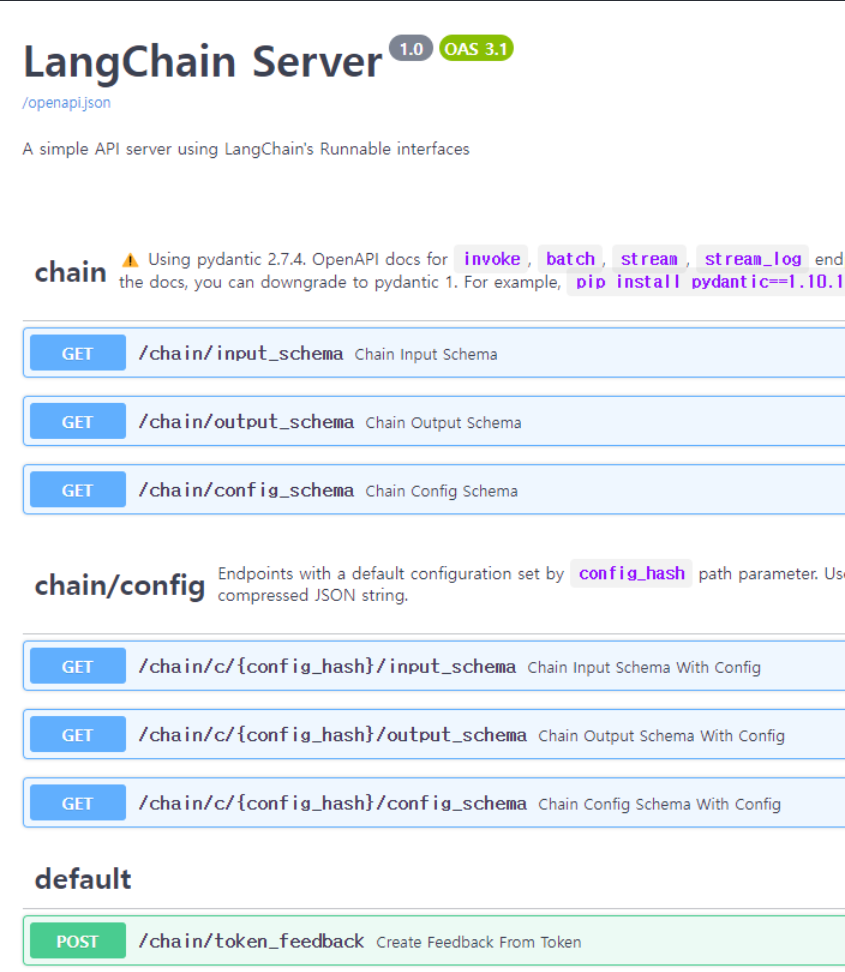

### Client

In [31]:
from langserve import RemoteRunnable

remote_chain = RemoteRunnable("http://localhost:8000/chain/")
remote_chain.invoke({"language": "italian", "text": "hi"})

'Ciao'

## Playground
http://localhost:8000/chain/playground/

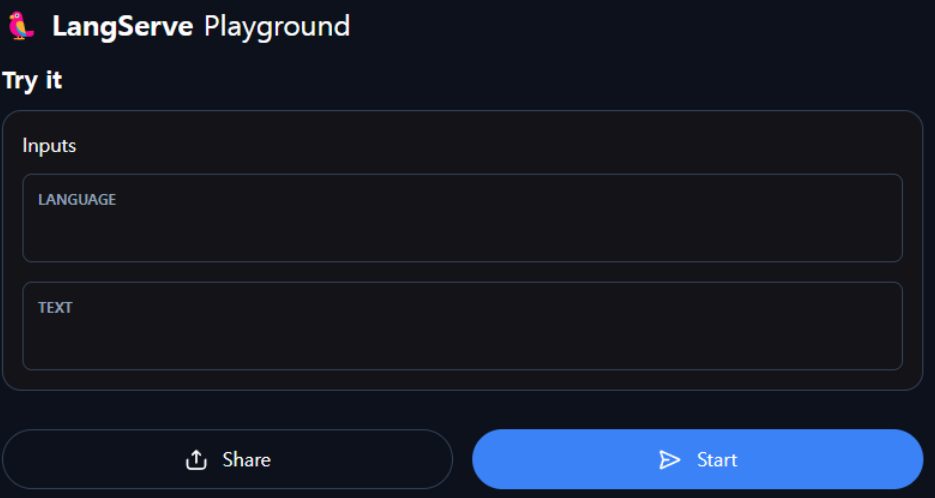